<a href="https://colab.research.google.com/github/Hashhhhhhhh/Raman-modified-NLSE/blob/main/Stochastic_NLSE_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Time resolution: 0.98 fs
Time window: 1.0 ps
Initial peak power: 5000 W
Nonlinear length: 0.1538 m
Dispersion length: 0.1250 m
Running classical simulation...
Propagating from 0.000 to 0.050 m
Step size: 0.001000 m, Total steps: 51
Quantum noise: Disabled
Progress: 9.8%


/tmp/ipython-input-3649457155.py:74: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  R_raman = R_raman / (np.trapz(R_raman, t_span) if np.trapz(R_raman, t_span) > 0 else 1)
/tmp/ipython-input-3649457155.py:128: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  raman_contribution[j] = np.trapz(integrand, t_span[:j+1])


Progress: 19.6%
Progress: 29.4%
Progress: 39.2%
Progress: 49.0%
Progress: 58.8%
Progress: 68.6%
Progress: 78.4%
Progress: 88.2%
Progress: 98.0%
Running 3 quantum simulations...
  Realization 1/3
Propagating from 0.000 to 0.050 m
Step size: 0.001000 m, Total steps: 51
Quantum noise: Enabled
Noise strength factor: 0.1
Progress: 9.8%
Progress: 19.6%
Progress: 29.4%
Progress: 39.2%
Progress: 49.0%
Progress: 58.8%
Progress: 68.6%
Progress: 78.4%
Progress: 88.2%
Progress: 98.0%
  Realization 2/3
Propagating from 0.000 to 0.050 m
Step size: 0.001000 m, Total steps: 51
Quantum noise: Enabled
Noise strength factor: 0.1
Progress: 9.8%
Progress: 19.6%
Progress: 29.4%
Progress: 39.2%
Progress: 49.0%
Progress: 58.8%
Progress: 68.6%
Progress: 78.4%
Progress: 88.2%
Progress: 98.0%
  Realization 3/3
Propagating from 0.000 to 0.050 m
Step size: 0.001000 m, Total steps: 51
Quantum noise: Enabled
Noise strength factor: 0.1
Progress: 9.8%
Progress: 19.6%
Progress: 29.4%
Progress: 39.2%
Progress: 49.0%
Pro

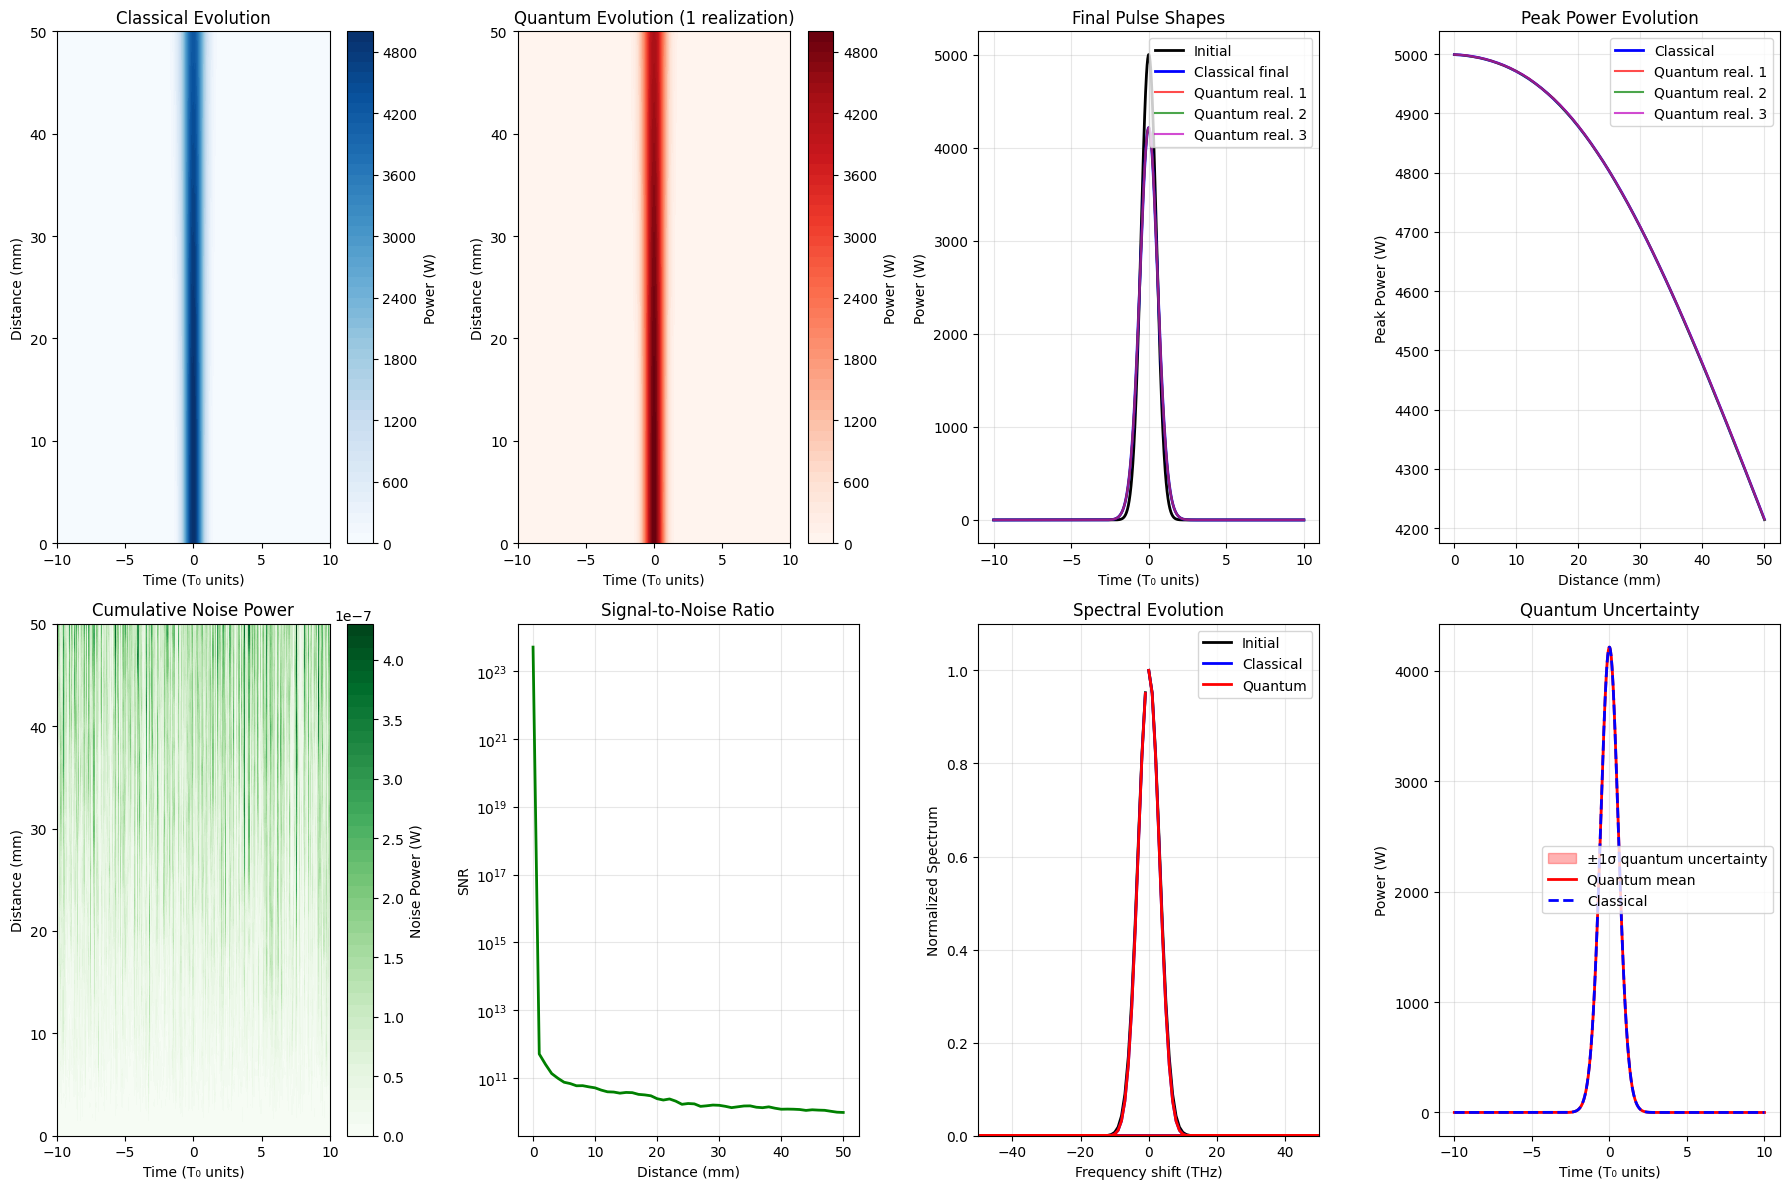

Propagation distance: 50.00 mm
Noise strength factor: 0.1
Number of quantum realizations: 3

Classical Results:
  Initial peak power: 4999.0 W
  Final peak power: 4214.5 W
  Power change: -15.7%

Quantum Results (statistics over realizations):
  Mean final peak power: 4214.2 ± 0.5 W
  Classical-quantum difference: -0.01%
  Final SNR: 8.9e+09 ± 1.2e+09


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq

def raman_response_function(t, tau1=12.2e-15, tau2=32e-15):
    """
    Raman response function R(t) for silica fiber
    """
    t = np.asarray(t)
    result = np.zeros_like(t)
    mask = t > 0
    result[mask] = ((tau1**2 + tau2**2) / (tau1 * tau2**2) *
                    np.exp(-t[mask]/tau2) * np.sin(t[mask]/tau1))
    return result

def generate_quantum_noise(N, dt, dz, hbar=1.055e-34):
    """
    Generate quantum noise terms for the stochastic NLSE

    Parameters:
    N: number of time points
    dt: time step
    dz: propagation step
    hbar: reduced Planck constant

    Returns:
    Gamma_linear: Linear quantum noise Γ(t,z)
    Gamma_raman: Raman quantum noise Γᴿ(t,z)
    """
    # Variance for quantum noise (zero-mean, delta-correlated)
    # Noise strength is proportional to sqrt(ħω₀/(2dz))
    omega0 = 2 * np.pi * 1.93e14  # Angular frequency at 1550 nm
    noise_variance = np.sqrt(hbar * omega0 / (2 * dz))

    # Generating complex Gaussian white noise
    Gamma_linear = (noise_variance / np.sqrt(dt)) * (
        np.random.randn(N) + 1j * np.random.randn(N)
    )

    Gamma_raman = (noise_variance / np.sqrt(dt)) * (
        np.random.randn(N) + 1j * np.random.randn(N)
    )

    return Gamma_linear, Gamma_raman

def solve_quantum_raman_nlse(A0, z_span, t_span, beta2, gamma, alpha, fr=0.18,
                            dz=None, include_quantum_noise=True, noise_strength=1.0):
    """
    Quantum solver for Raman-modified stochastic NLSE with quantum noise terms

    Parameters:
    include_quantum_noise: Enable/disable quantum noise terms
    noise_strength: Scaling factor for noise strength (1.0 = full quantum noise)
    """
    # Grid
    dt = t_span[1] - t_span[0]
    N = len(t_span)

    # Adaptive step size based on nonlinearity
    if dz is None:
        P0 = np.max(np.abs(A0)**2)
        dz = min(0.001, 1/(gamma * P0 * 20))

    z_points = np.arange(z_span[0], z_span[1] + dz, dz)

    # Frequency domain
    omega = 2 * np.pi * fftfreq(N, dt)

    # Field initialization
    A = A0.copy().astype(complex)

    # Raman response
    R_raman = raman_response_function(t_span)
    R_raman = R_raman / (np.trapz(R_raman, t_span) if np.trapz(R_raman, t_span) > 0 else 1)

    # Storage
    save_every = max(1, len(z_points) // 100)
    saved_indices = range(0, len(z_points), save_every)
    A_evolution = np.zeros((len(saved_indices), len(A0)), dtype=complex)
    noise_evolution = np.zeros((len(saved_indices), len(A0)), dtype=complex)  # Track noise contribution
    saved_z = []
    save_idx = 0

    # Initial condition
    A_evolution[0] = A0
    noise_evolution[0] = np.zeros_like(A0)
    saved_z.append(z_points[0])
    save_idx = 1

    print(f"Propagating from {z_span[0]:.3f} to {z_span[1]:.3f} m")
    print(f"Step size: {dz:.6f} m, Total steps: {len(z_points)}")
    print(f"Quantum noise: {'Enabled' if include_quantum_noise else 'Disabled'}")
    if include_quantum_noise:
        print(f"Noise strength factor: {noise_strength}")

#cumulative noise
    cumulative_noise = np.zeros_like(A0, dtype=complex)

    for i, z in enumerate(z_points[1:], 1):
        if i % (len(z_points) // 10) == 0:
            print(f"Progress: {100*i/len(z_points):.1f}%")
        if include_quantum_noise:
            Gamma_linear, Gamma_raman = generate_quantum_noise(N, dt, dz)
            Gamma_linear *= noise_strength
            Gamma_raman *= noise_strength
        else:
            Gamma_linear = np.zeros(N, dtype=complex)
            Gamma_raman = np.zeros(N, dtype=complex)

        # Split-step method: Linear step (half)
        A_freq = fft(A)
        linear_phase = 1j * beta2 * omega**2 * dz / 4 - alpha * dz / 2
        A_freq *= np.exp(linear_phase)
        A = ifft(A_freq)

        # Nonlinear step with quantum noise
        intensity = np.abs(A)**2

        # Instantaneous Kerr response
        kerr_contribution = (1 - fr) * intensity

        # Delayed Raman response (convolution in time domain)
        raman_contribution = np.zeros_like(intensity)
        for j in range(len(t_span)):
            if j > 0:  # Only for t > 0
                # Trapezoidal integration for convolution
                integrand = R_raman[:j+1] * intensity[:j+1][::-1]
                raman_contribution[j] = np.trapz(integrand, t_span[:j+1])

        raman_contribution *= fr

        # Total nonlinear phase shift (classical part)
        nonlinear_phase_classical = 1j * gamma * (kerr_contribution + raman_contribution) * dz

        # Quantum noise contributions
        # Raman noise: iΓᴿ(t,z) term (multiplicative)
        raman_noise_phase = 1j * Gamma_raman * dz

        # Total nonlinear operator including Raman quantum noise
        total_nonlinear_phase = nonlinear_phase_classical + raman_noise_phase

        # Apply nonlinear operator
        A *= np.exp(total_nonlinear_phase)

        # Linear quantum noise: Γ(t,z) term (additive)
        linear_noise_contribution = Gamma_linear * dz
        A += linear_noise_contribution
        cumulative_noise += linear_noise_contribution

        # Linear step (second half)
        A_freq = fft(A)
        A_freq *= np.exp(linear_phase)
        A = ifft(A_freq)


        if i in saved_indices and save_idx < len(A_evolution):
            A_evolution[save_idx] = A
            noise_evolution[save_idx] = cumulative_noise
            saved_z.append(z)
            save_idx += 1

    return np.array(saved_z), A_evolution[:save_idx], noise_evolution[:save_idx]

def analyze_quantum_pulse_properties(t, A_evolution, noise_evolution, z_points):
    """
    Analyze pulse properties during quantum propagation including noise effects
    """
    powers = np.abs(A_evolution)**2
    peak_powers = np.max(powers, axis=1)

    # Noise power contribution
    noise_powers = np.abs(noise_evolution)**2
    peak_noise_powers = np.max(noise_powers, axis=1)

    # Pulse widths (FWHM)
    pulse_widths = []
    for i in range(len(z_points)):
        power = powers[i]
        peak_power = np.max(power)
        half_max_indices = np.where(power >= peak_power/2)[0]
        if len(half_max_indices) > 1:
            width = t[half_max_indices[-1]] - t[half_max_indices[0]]
            pulse_widths.append(width)
        else:
            pulse_widths.append(0)

    # Signal-to-noise ratio
    snr = peak_powers / (peak_noise_powers + 1e-20)

    return peak_powers, np.array(pulse_widths), peak_noise_powers, snr

def compare_classical_vs_quantum(A0, z_span, t_span, beta2, gamma, alpha, fr=0.18,
                                noise_strength=1.0, n_realizations=5):
    """
    Compare classical and quantum evolution with multiple noise realizations
    """
    print("Running classical simulation...")
    z_classical, A_classical, _ = solve_quantum_raman_nlse(
        A0, z_span, t_span, beta2, gamma, alpha, fr,
        include_quantum_noise=False
    )

    print(f"Running {n_realizations} quantum simulations...")
    quantum_results = []
    for i in range(n_realizations):
        print(f"  Realization {i+1}/{n_realizations}")
        z_quantum, A_quantum, noise_quantum = solve_quantum_raman_nlse(
            A0, z_span, t_span, beta2, gamma, alpha, fr,
            include_quantum_noise=True, noise_strength=noise_strength
        )
        quantum_results.append((z_quantum, A_quantum, noise_quantum))

    return z_classical, A_classical, quantum_results

if __name__ == "__main__":
    # Pulse parameters
    T0 = 50e-15    # 50 fs pulse
    P0 = 5000      # 5 kW peak power

    # Fiber parameters
    beta2 = -2e-26     # s²/m (anomalous dispersion at 1550 nm)
    gamma = 1.3e-3     # 1/(W·m) (typical nonlinear coefficient)
    alpha = 0.046      # Loss coefficient (0.2 dB/km)
    fr = 0.18          # Raman fraction for silica

    # Grid
    t_window = 20 * T0
    N_t = 1024
    t = np.linspace(-t_window/2, t_window/2, N_t)
    dt = t[1] - t[0]

    print(f"Time resolution: {dt*1e15:.2f} fs")
    print(f"Time window: {t_window*1e12:.1f} ps")

    # Initial Gaussian pulse
    A0 = np.sqrt(P0) * np.exp(-(t/(T0))**2)

    # Propagation distance
    z_span = (0, 0.05)  # Shorter distance to see quantum effects clearly

    print(f"Initial peak power: {P0} W")
    print(f"Nonlinear length: {1/(gamma*P0):.4f} m")
    print(f"Dispersion length: {T0**2/np.abs(beta2):.4f} m")

    # Compare classical vs quantum
    noise_strength = 0.1
    n_realizations = 3

    z_classical, A_classical, quantum_results = compare_classical_vs_quantum(
        A0, z_span, t, beta2, gamma, alpha, fr, noise_strength, n_realizations
    )


    peak_powers_classical, pulse_widths_classical, _, _ = analyze_quantum_pulse_properties(
        t, A_classical, np.zeros_like(A_classical), z_classical
    )

    fig = plt.figure(figsize=(18, 12))

    # Classical vs Quantum pulse evolution comparison
    ax1 = plt.subplot(2, 4, 1)
    power_classical = np.abs(A_classical)**2
    contour1 = ax1.contourf(t/T0, z_classical*1000, power_classical, levels=50, cmap='Blues')
    ax1.set_xlabel('Time (T₀ units)')
    ax1.set_ylabel('Distance (mm)')
    ax1.set_title('Classical Evolution')
    plt.colorbar(contour1, ax=ax1, label='Power (W)')

    ax2 = plt.subplot(2, 4, 2)
    # first quantum realization
    z_quantum, A_quantum, noise_quantum = quantum_results[0]
    power_quantum = np.abs(A_quantum)**2
    contour2 = ax2.contourf(t/T0, z_quantum*1000, power_quantum, levels=50, cmap='Reds')
    ax2.set_xlabel('Time (T₀ units)')
    ax2.set_ylabel('Distance (mm)')
    ax2.set_title('Quantum Evolution (1 realization)')
    plt.colorbar(contour2, ax=ax2, label='Power (W)')

    #Final pulse comparison
    ax3 = plt.subplot(2, 4, 3)
    ax3.plot(t/T0, np.abs(A0)**2, 'k-', label='Initial', linewidth=2)
    ax3.plot(t/T0, np.abs(A_classical[-1])**2, 'b-', label='Classical final', linewidth=2)

    colors = ['r-', 'g-', 'm-']
    for i, (z_q, A_q, _) in enumerate(quantum_results):
        ax3.plot(t/T0, np.abs(A_q[-1])**2, colors[i],
                label=f'Quantum real. {i+1}', linewidth=1.5, alpha=0.7)

    ax3.set_xlabel('Time (T₀ units)')
    ax3.set_ylabel('Power (W)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_title('Final Pulse Shapes')

    #Peak power evolution
    ax4 = plt.subplot(2, 4, 4)
    ax4.plot(z_classical*1000, peak_powers_classical, 'b-', linewidth=2, label='Classical')

    for i, (z_q, A_q, noise_q) in enumerate(quantum_results):
        peak_powers_q, _, peak_noise_q, _ = analyze_quantum_pulse_properties(t, A_q, noise_q, z_q)
        ax4.plot(z_q*1000, peak_powers_q, colors[i], linewidth=1.5, alpha=0.7,
                label=f'Quantum real. {i+1}')

    ax4.set_xlabel('Distance (mm)')
    ax4.set_ylabel('Peak Power (W)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_title('Peak Power Evolution')

    #Noise contribution
    ax5 = plt.subplot(2, 4, 5)
    z_q, A_q, noise_q = quantum_results[0]
    noise_power = np.abs(noise_q)**2
    contour3 = ax5.contourf(t/T0, z_q*1000, noise_power, levels=50, cmap='Greens')
    ax5.set_xlabel('Time (T₀ units)')
    ax5.set_ylabel('Distance (mm)')
    ax5.set_title('Cumulative Noise Power')
    plt.colorbar(contour3, ax=ax5, label='Noise Power (W)')

    #Signal-to-noise ratio
    ax6 = plt.subplot(2, 4, 6)
    _, _, peak_noise_q, snr = analyze_quantum_pulse_properties(t, A_q, noise_q, z_q)
    ax6.semilogy(z_q*1000, snr, 'g-', linewidth=2)
    ax6.set_xlabel('Distance (mm)')
    ax6.set_ylabel('SNR')
    ax6.grid(True, alpha=0.3)
    ax6.set_title('Signal-to-Noise Ratio')

    #Spectral evolution comparison
    ax7 = plt.subplot(2, 4, 7)
    freq = fftfreq(len(t), dt)
    freq_shift_THz = freq / 1e12

    spectrum_initial = np.abs(fft(A0))**2
    spectrum_classical = np.abs(fft(A_classical[-1]))**2
    spectrum_quantum = np.abs(fft(A_quantum[-1]))**2

    ax7.plot(freq_shift_THz, spectrum_initial/np.max(spectrum_initial), 'k-',
             label='Initial', linewidth=2)
    ax7.plot(freq_shift_THz, spectrum_classical/np.max(spectrum_classical), 'b-',
             label='Classical', linewidth=2)
    ax7.plot(freq_shift_THz, spectrum_quantum/np.max(spectrum_quantum), 'r-',
             label='Quantum', linewidth=2)

    ax7.set_xlim(-50, 50)
    ax7.set_ylim(0, 1.1)
    ax7.set_xlabel('Frequency shift (THz)')
    ax7.set_ylabel('Normalized Spectrum')
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    ax7.set_title('Spectral Evolution')

    #Quantum uncertainty visualization
    ax8 = plt.subplot(2, 4, 8)

    # ensemble statistics from multiple realizations
    final_powers = []
    for z_q, A_q, _ in quantum_results:
        final_powers.append(np.abs(A_q[-1])**2)

    final_powers = np.array(final_powers)
    mean_power = np.mean(final_powers, axis=0)
    std_power = np.std(final_powers, axis=0)

    ax8.fill_between(t/T0, mean_power - std_power, mean_power + std_power,
                     alpha=0.3, color='red', label='±1σ quantum uncertainty')
    ax8.plot(t/T0, mean_power, 'r-', linewidth=2, label='Quantum mean')
    ax8.plot(t/T0, np.abs(A_classical[-1])**2, 'b--', linewidth=2, label='Classical')

    ax8.set_xlabel('Time (T₀ units)')
    ax8.set_ylabel('Power (W)')
    ax8.legend()
    ax8.grid(True, alpha=0.3)
    ax8.set_title('Quantum Uncertainty')

    plt.tight_layout()
    plt.show()

    print(f"Propagation distance: {z_classical[-1]*1000:.2f} mm")
    print(f"Noise strength factor: {noise_strength}")
    print(f"Number of quantum realizations: {n_realizations}")

    print("\nClassical Results:")
    print(f"  Initial peak power: {peak_powers_classical[0]:.1f} W")
    print(f"  Final peak power: {peak_powers_classical[-1]:.1f} W")
    print(f"  Power change: {100*(peak_powers_classical[-1]/peak_powers_classical[0]-1):.1f}%")

    print("\nQuantum Results (statistics over realizations):")
    final_peak_powers = [analyze_quantum_pulse_properties(t, A_q, noise_q, z_q)[0][-1]
                        for z_q, A_q, noise_q in quantum_results]
    mean_final_power = np.mean(final_peak_powers)
    std_final_power = np.std(final_peak_powers)

    print(f"  Mean final peak power: {mean_final_power:.1f} ± {std_final_power:.1f} W")
    print(f"  Classical-quantum difference: {100*(mean_final_power/peak_powers_classical[-1]-1):.2f}%")

    # SNR statistics
    snr_final = [analyze_quantum_pulse_properties(t, A_q, noise_q, z_q)[3][-1]
                for z_q, A_q, noise_q in quantum_results]
    print(f"  Final SNR: {np.mean(snr_final):.1e} ± {np.std(snr_final):.1e}")